**tradMIMO**<br>
by $\text{Rishabh Pomaje}$

- This file contains the simulations of a $2 \times 2$ **S**ingular-**V**alue **D**ecomposition (SVD) - based conventional communication system. 
- The results are meant to be used as benchmarks for the DNN learnt in the file $\color{gold}{deepMIMO.ipynb}$
- Two pipelines are considered as follows :
    1. Without any channel coding
    2. With Hamming (7, 4) channel coding<br>
        a. Hard Decision + Syndrome-based correction 

In [116]:
# Dependencies :
import numpy as np 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg'

- Function Definitions

In [117]:
# Importing from custom made module CommSysLib
import CommSysLib as csl

- System Parameters

In [118]:
k, n = 4, 7         # Uncoded and coded block lengths
R = k / n           # Information rate
E_b = 1             # Energy per bit

# SNR range in dB and linear scale
n_points = 30
SNR_dB = np.linspace(-2, 20, n_points)
SNR_lin = 10 ** (SNR_dB / 10)
noise_var_uncoded = 1 / (2 * SNR_lin)
noise_var_coded = 1 / (2 * R * SNR_lin)

# Fading model : Rayleigh Fading 
fade_mean, fade_std = 0, np.sqrt(0.5)

- Data generation (Random binary data)

In [119]:
n_bits = 10 ** 5
n_bits_c = n * n_bits // k
binary_stream_tx = np.random.randint(0, 2, n_bits)

print(f'Samples : {binary_stream_tx[:10]}')

Samples : [1 1 0 0 1 0 0 0 1 1]


### Without channel coding

- Transmission

In [120]:
def svdMIMOencoder(input_stream, csi, E_b=1):
    """ 
    Function to perform SVD-based precoding for a 2 x 2 MIMO Rayleigh Channel Model
    """
    output_stream = []
    num_pckts = len(csi)
    idx = 0 
    E_b = 1
    for i in range(num_pckts):
        # Processing two bits at a time
        tempSeq = input_stream[idx:idx+2]
        x = csl.BPSK_mapper(tempSeq, E_b)
        # Precombining using the CSI
        _, _, Vh = np.linalg.svd(csi[i])
        s = Vh @ x
        # Normalizing
        s = np.array(E_b) * s / np.linalg.norm(s)
        output_stream.append(s)
        idx += 2
    
    return np.array(output_stream)

def svdMIMOdecoder(input_stream, csi):
    """ 
    Function to perform svd-based decoding for a Rayleigh Channel model and 2 x 2 system.  
    """
    output_stream = []
    idx = 0 
    for i in range(len(input_stream)):
        # Extract the received symbols:
        y = input_stream[i]
        U, _, _ = np.linalg.svd(csi[i])
        y_combined = np.conjugate(U.T) @ y
        output_stream.append(csl.BPSK_demapper(y_combined))
        idx += 2
    return np.array(output_stream).flatten()


In [121]:
# Fading taps
fade_taps = np.random.normal(fade_mean, fade_std, (n_bits//2, 2, 2)) + 1j * np.random.normal(fade_mean, fade_std, (n_bits//2, 2, 2))

signal_stream_tx = svdMIMOencoder(binary_stream_tx, fade_taps, 1)

- Simulating the channel and the decoding

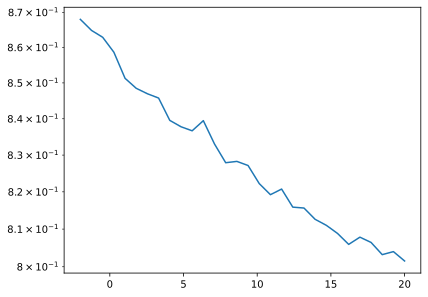

In [122]:
BLER_uncoded_svd = []
count = 0 
for noise in noise_var_uncoded: 
    # Fading :
    faded_signal_rx = []
    for i in range(n_bits//2): 
        faded_signal_rx.append(fade_taps[i] @ signal_stream_tx[i])
    # Noise : 
    noise_samples = np.random.normal(0, np.sqrt(noise), (n_bits//2, 2)) + 1j * np.random.normal(0, np.sqrt(noise), (n_bits//2, 2))
    signal_stream_rx = faded_signal_rx + noise_samples
    # Decoding : 
    binary_stream_rx = svdMIMOdecoder(signal_stream_rx, fade_taps)
    # Analysis : 
    _, BLER = csl.calcBLER(binary_stream_tx, binary_stream_rx, 1)
    BLER_uncoded_svd.append(BLER)
    # Progress Update :
    count += 1 
    print(f'Progress : {100 * count // n_points} %', end='\r')

plt.semilogy(SNR_dB, BLER_uncoded_svd)

### With Channel Coding

- Channel coding

- Constellation Mapping

- Transmission 

- Simulating the channel and the decoding